In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#Benford's Law is using someone else GitHub repo
from benfordslaw import benfordslaw

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils import resample
from sklearn.decomposition import PCA


from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import classification_report

# This module lets us save our models once we fit them.
import pickle


# Financial Fraud dataset from Kaggle

In [2]:
df = pd.read_csv('C:/Users/Hp/Downloads/Synthetic_Financial_datasets_log/Synthetic_Financial_datasets_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [11]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [12]:
df.shape

(6362620, 11)

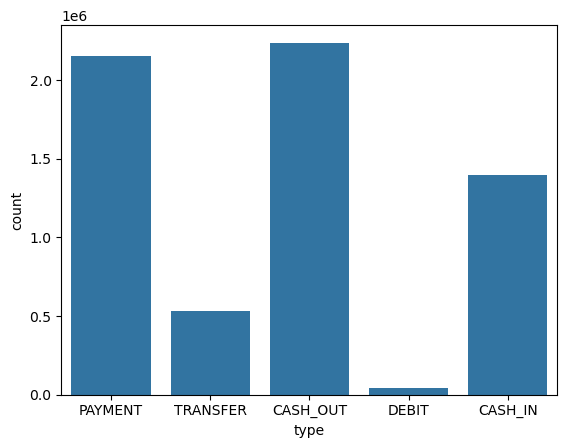

In [13]:
sns.countplot(x='type', data=df)
plt.show()

In [14]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [15]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [16]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

# Dataset Structure

- **step**: Represents a unit of time in the real world, with 1 step equating to 1 hour. The total simulation spans 744 steps, equivalent to 30 days.

- **type**: Transaction types include `CASH-IN`, `CASH-OUT`, `DEBIT`, `PAYMENT`, and `TRANSFER`.

- **amount**: The transaction amount in the local currency.

- **nameOrig**: The customer initiating the transaction.

- **oldbalanceOrg**: The initial balance before the transaction.

- **newbalanceOrig**: The new balance after the transaction.

- **nameDest**: The transaction's recipient customer.

- **oldbalanceDest**: The initial recipient's balance before the transaction. Not applicable for customers identified by `'M'` (Merchants).

- **newbalanceDest**: The new recipient's balance after the transaction. Not applicable for `'M'` (Merchants).

- **isFraud**: Identifies transactions conducted by fraudulent agents aiming to deplete customer accounts through transfers and cash-outs.

- **isFlaggedFraud**: Flags large-scale, unauthorized transfers between accounts, with any single transaction exceeding **200,000** being considered illegal.
ed illegal.

C:\Users\Hp\AppData\Local\Temp\ipykernel_15468\395256865.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['step'], bins=50)


<Axes: xlabel='step', ylabel='Density'>

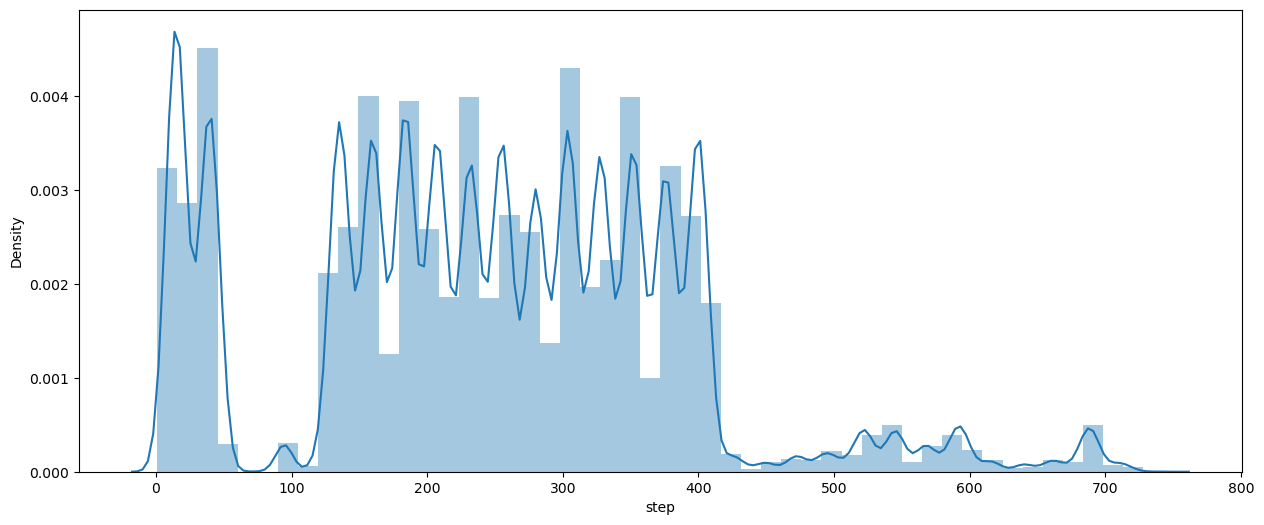

In [18]:
plt.figure(figsize=(15, 6))
sns.distplot(df['step'], bins=50)

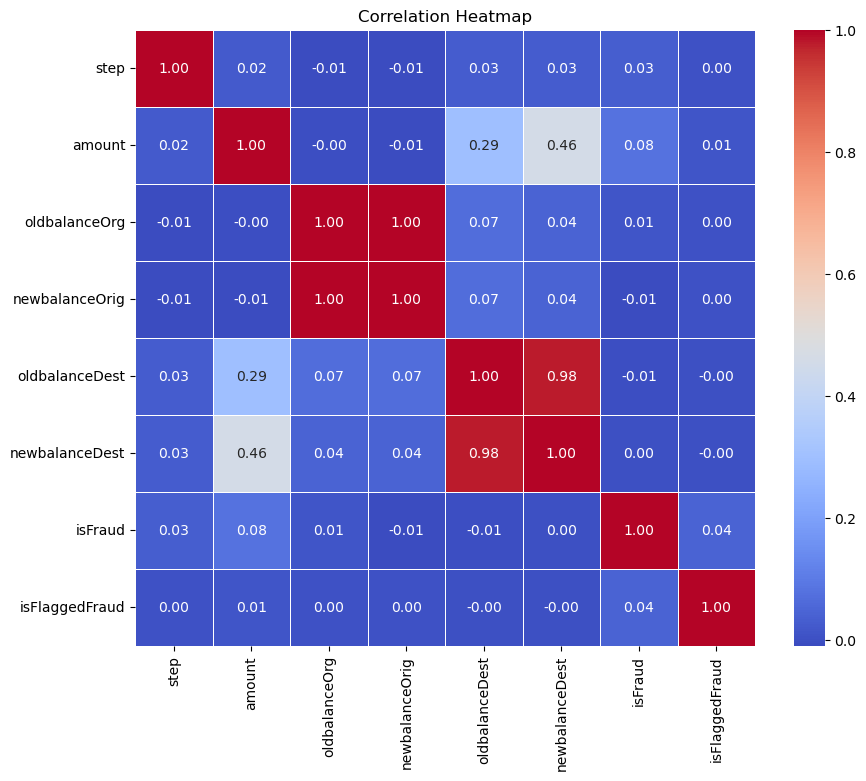

In [19]:
cor = df.select_dtypes(include='number').corr(method='pearson')
# Plot heatmap
plt.figure(figsize=(10, 8))  # Optional: adjust size
sns.heatmap(cor, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# isFraud
- Identifies transactions conducted by fraudulent agents aiming to deplete customer accounts through transfers and cash-outs.

In [21]:
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [22]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [166]:
df[df['isFraud'] == 1]['type'].value_counts()

type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64

- Total of fraud happening from CASH_OUT and Transfer type of transaction should be equal to the total fraud happened.

In [178]:
df[['type', 'isFraud']].value_counts()

type      isFraud
CASH_OUT  0          2233384
PAYMENT   0          2151495
CASH_IN   0          1399284
TRANSFER  0           528812
DEBIT     0            41432
CASH_OUT  1             4116
TRANSFER  1             4097
Name: count, dtype: int64

# To observe the difference of Non-fraud and Fraud transactions

In [180]:
df[(df['type'] == 'CASH_OUT') & (df['isFraud'] == 0)].head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_cluster,oldbalanceOrg_cluster,newbalanceOrig_cluster,oldbalanceDest_cluster,newbalanceDest_cluster,step_cluster
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.00,C476402209,5083.0,51513.44,0,0,0,0,0,2,0,2
42,1,CASH_OUT,110414.71,C768216420,26845.41,0.00,C1509514333,288800.0,2415.16,0,0,0,0,0,2,0,2
47,1,CASH_OUT,56953.90,C1570470538,1942.02,0.00,C824009085,70253.0,64106.18,0,0,0,0,0,2,0,2
48,1,CASH_OUT,5346.89,C512549200,0.00,0.00,C248609774,652637.0,6453430.91,0,0,0,0,0,2,2,2
51,1,CASH_OUT,23261.30,C2072313080,20411.53,0.00,C2001112025,25742.0,0.00,0,0,0,0,0,2,0,2
60,1,CASH_OUT,82940.31,C1528834618,3017.87,0.00,C476800120,132372.0,49864.36,0,0,0,0,0,2,0,2
70,1,CASH_OUT,47458.86,C527211736,209534.84,162075.98,C2096057945,52120.0,0.00,0,0,0,0,0,2,0,2
71,1,CASH_OUT,136872.92,C1533123860,162075.98,25203.05,C766572210,217806.0,0.00,0,0,0,0,0,2,0,2
72,1,CASH_OUT,94253.33,C1718906711,25203.05,0.00,C977993101,99773.0,965870.05,0,0,0,0,0,2,0,2
106,1,CASH_OUT,28404.60,C2091072548,0.00,0.00,C1282788025,51744.0,0.00,0,0,0,0,0,2,0,2


In [182]:
df[(df['type'] == 'CASH_OUT') & (df['isFraud'] == 1)].head(10)
df[(df['type'] == 'CASH_OUT') & (df['isFraud'] == 1)]['newbalanceOrig'].value_counts()

newbalanceOrig
0.00         4115
298767.61       1
Name: count, dtype: int64

- All of the newbalanceOrig account got depleted after the fraud happened.

In [183]:
df[(df['type'] == 'TRANSFER') & (df['isFraud'] == 0)].head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_cluster,oldbalanceOrg_cluster,newbalanceOrig_cluster,oldbalanceDest_cluster,newbalanceDest_cluster,step_cluster
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0,0,0,0,2,0,2
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0,0,0,0,2,0,2
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0,0,0,0,0,2,0,2
78,1,TRANSFER,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0,0,0,0,0,2,0,2
79,1,TRANSFER,77957.68,C207471778,0.00,0.0,C1761291320,94900.00,22233.65,0,0,0,0,0,2,0,2
80,1,TRANSFER,17231.46,C1243171897,0.00,0.0,C783286238,24672.00,0.00,0,0,0,0,0,2,0,2
81,1,TRANSFER,78766.03,C1376151044,0.00,0.0,C1749186397,103772.00,277515.05,0,0,0,0,0,2,0,2
82,1,TRANSFER,224606.64,C873175411,0.00,0.0,C766572210,354678.92,0.00,0,0,0,0,0,2,0,2
83,1,TRANSFER,125872.53,C1443967876,0.00,0.0,C392292416,348512.00,3420103.09,0,0,0,0,0,2,0,2
84,1,TRANSFER,379856.23,C1449772539,0.00,0.0,C1590550415,900180.00,19169204.93,0,0,0,0,0,2,1,2


In [192]:
df[(df['type'] == 'TRANSFER') & (df['isFraud'] == 1)].head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_cluster,oldbalanceOrg_cluster,newbalanceOrig_cluster,oldbalanceDest_cluster,newbalanceDest_cluster,step_cluster
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.0,1,0,0,0,0,2,0,2
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.0,0.0,1,0,0,0,0,2,0,2
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.0,0.0,1,0,0,0,0,2,0,2
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.0,0.0,1,0,2,0,0,2,0,2
1115,1,TRANSFER,35063.63,C1364127192,35063.63,0.0,C1136419747,0.0,0.0,1,0,0,0,0,2,0,2
1869,1,TRANSFER,25071.46,C669700766,25071.46,0.0,C1384210339,0.0,0.0,1,0,0,0,0,2,0,2
2301,1,TRANSFER,235238.66,C1872047468,235238.66,0.0,C116289363,0.0,0.0,1,0,0,0,0,2,0,2
3059,2,TRANSFER,1096187.24,C1093223281,1096187.24,0.0,C2063275841,0.0,0.0,1,0,2,0,0,2,0,2
3162,2,TRANSFER,963532.14,C1440057381,963532.14,0.0,C268086000,0.0,0.0,1,0,2,0,0,2,0,2
3271,2,TRANSFER,14949.84,C140702728,14949.84,0.0,C634210724,0.0,0.0,1,0,0,0,0,2,0,2


In [194]:
num = df[(df['type'] == 'TRANSFER') & (df['isFraud'] == 1) & (df['newbalanceOrig'] == 0.00)]['newbalanceOrig'].value_counts().sum()
print(f"newbalanceOrig: {(num/4097) * 100}%")

newbalanceOrig: 96.11911154503295%


# To understand 'isFlaggedFraud' column

In [185]:
print(f"Flagged Fraud Min:{df[df['isFlaggedFraud'] == 1]['amount'].min()} & Max:{df[df['isFlaggedFraud'] == 1]['amount'].max()}")

Flagged Fraud Min:353874.22 & Max:10000000.0


In [186]:
df['amount'].max()

92445516.64

In [23]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [24]:
df[df['isFlaggedFraud'] == 1].head(20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


- Every occurence of 'isFlaggedFraud' == 1 must have 'isFraud' == 1

- Calculate how many row of data contain in financial fraud dataset

In [7]:
df_fraud = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]
df_fraud['type'].unique()
df_fraud.shape

(2770409, 11)

In [26]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [27]:
df_fraud[df_fraud['isFraud'] == 1].head(20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
681,1,CASH_OUT,20128.00,C1118430673,20128.00,0.0,C339924917,6268.00,12145.85,1,0
724,1,CASH_OUT,416001.33,C749981943,0.00,0.0,C667346055,102.00,9291619.62,1,0
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.00,0.00,1,0
970,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.0,C716083600,0.00,2444985.19,1,0
1115,1,TRANSFER,35063.63,C1364127192,35063.63,0.0,C1136419747,0.00,0.00,1,0


In [28]:
df_fraud[df_fraud['isFraud'] == 1]['newbalanceOrig'].value_counts()

newbalanceOrig
0.00           8053
17316255.05       3
10399045.08       3
19585040.37       3
4953893.08        2
               ... 
34892193.09       1
1975271.77        1
11975271.77       1
1653144.10        1
29585040.37       1
Name: count, Length: 145, dtype: int64

In [29]:
df_fraud[df_fraud['isFraud'] == 0].head(20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.00,C476402209,5083.00,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.00,C1100439041,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.00,C932583850,6267.00,2719172.89,0,0
42,1,CASH_OUT,110414.71,C768216420,26845.41,0.00,C1509514333,288800.00,2415.16,0,0
47,1,CASH_OUT,56953.90,C1570470538,1942.02,0.00,C824009085,70253.00,64106.18,0,0
48,1,CASH_OUT,5346.89,C512549200,0.00,0.00,C248609774,652637.00,6453430.91,0,0
51,1,CASH_OUT,23261.30,C2072313080,20411.53,0.00,C2001112025,25742.00,0.00,0,0
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.20,C1937962514,517.00,8383.29,0,0
60,1,CASH_OUT,82940.31,C1528834618,3017.87,0.00,C476800120,132372.00,49864.36,0,0
70,1,CASH_OUT,47458.86,C527211736,209534.84,162075.98,C2096057945,52120.00,0.00,0,0


# Using Logistic Regression model

- Logistics Regression supports multiple dependent variable(x variable)

In [13]:
df1_fraud = df_fraud.copy()
x_list = df1_fraud[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
y = df1_fraud['isFraud']

#30% will go to training set, and 70% will go to data testing set
x_train, x_test, y_train, y_test = train_test_split(x_list, y, test_size=0.3, random_state=42)

In [10]:
# Calling Logistic Regression
model = LogisticRegression()

#Train the model with training dataset
results = model.fit(x_train, y_train)

#print the coefficient and intercept of the model after trained dataset
print(results.coef_)
print(results.intercept_)

#After the training, then we use testing dataset to predict the fraud occurence
#.predict() set threshold at 0.5 by default, if you want to adjust, then do .predict_proba_(), you may refer to the documentation
y_pred = results.predict(x_test)

#Metrics/indicators to determine how well our model to predict fraud
print("Accuracy:", "%.6f" % metrics.accuracy_score(y_test, y_pred))
print("Precision:", "%.6f" % metrics.precision_score(y_test, y_pred))
print("Recall:", "%.6f" % metrics.recall_score(y_test, y_pred))
print("F1 Score:", "%.6f" % metrics.f1_score(y_test, y_pred))

[[-1.77985658e-05  3.14169785e-05 -3.49297193e-05  5.33869871e-06
  -5.62233828e-06]]
[-5.35924559]
Accuracy: 0.998251
Precision: 0.912837
Recall: 0.461538
F1 Score: 0.613092


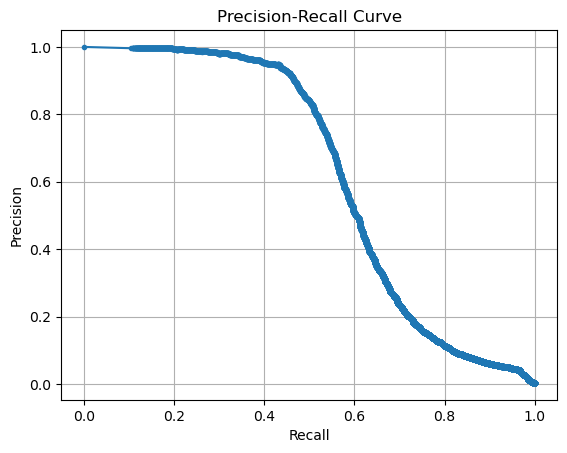

Best Threshold for Max F1: 0.24953554642796857


In [32]:
from sklearn.metrics import precision_recall_curve, f1_score

# Predict probabilities instead of labels
#if the threshold not set, then it's 0.5 by default
y_probs = model.predict_proba(x_test)[:, 1]  # get probabilities for class 1

# Get precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot logistic regression graph
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()
# Compute F1 for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # add epsilon to avoid div-by-zero

# Find and print the best threshold
best_threshold = thresholds[f1_scores.argmax()]
print("Best Threshold for Max F1:", best_threshold)

# Apply it
y_pred_new = (y_probs >= best_threshold).astype(int)

In [33]:
#Display metric scores
print("Accuracy:", "%.6f" % metrics.accuracy_score(y_test, y_pred_new))
print("Precision:", "%.6f" % metrics.precision_score(y_test, y_pred_new))
print("Recall:", "%.6f" % metrics.recall_score(y_test, y_pred_new))
print("F1 Score:", "%.6f" % metrics.f1_score(y_test, y_pred_new))

Accuracy: 0.998202
Precision: 0.826172
Recall: 0.508413
F1 Score: 0.629464


# Tuning threshold not working ^

- Why not working because the recall score is not good enough for the industrial standard nowadays, at least 0.7.
- A recall score of 0.5 means that your model correctly identified 50% of all actual positive cases.
- The other 50 were missed—classified as negative even though they were actually positive.

# SMOTE
- Then here I try SMOTE, where SMOTE creates synthetic samples of the minority class (e.g., isFraud = 1) to balance the dataset.

In [36]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE on training set only!
sm = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = sm.fit_resample(x_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())

# Fit model on resampled data
model = LogisticRegression()
result = model.fit(x_train_resampled, y_train_resampled)
y_pred_smote = result.predict(x_test)
print("Accuracy:", "%.6f" % metrics.accuracy_score(y_test, y_pred_smote))
print("Precision:", "%.6f" % metrics.precision_score(y_test, y_pred_smote))
print("Recall:", "%.6f" % metrics.recall_score(y_test, y_pred_smote))
print("F1 Score:", "%.6f" % metrics.f1_score(y_test, y_pred_smote))

Before SMOTE: isFraud
0    1933569
1       5717
Name: count, dtype: int64
After SMOTE: isFraud
0    1933569
1    1933569
Name: count, dtype: int64
Accuracy: 0.899947
Precision: 0.028447
Recall: 0.974760
F1 Score: 0.055282


- Using SMOTE not working as well to improve the metrics score

<Axes: xlabel='oldbalanceOrg', ylabel='isFraud'>

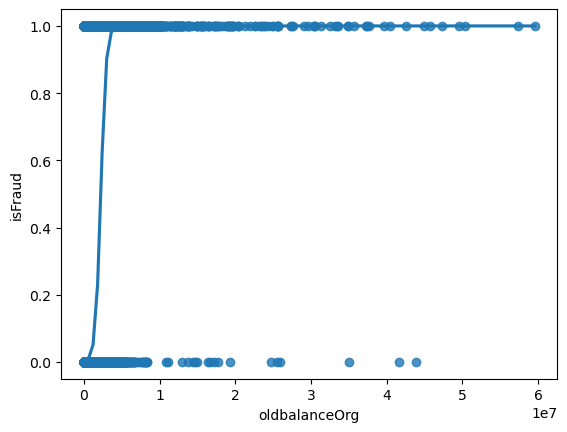

In [38]:
x_list = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
sns.regplot(x='oldbalanceOrg', y="isFraud", data=df1_fraud, logistic=True, ci=None)

<Axes: xlabel='newbalanceOrig', ylabel='isFraud'>

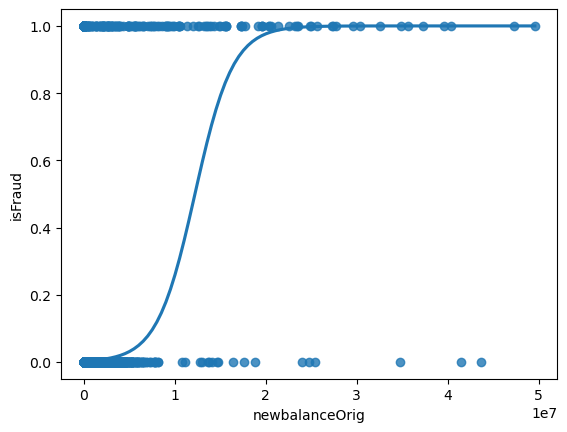

In [39]:
x_list = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
sns.regplot(x='newbalanceOrig', y="isFraud", data=df1_fraud, logistic=True, ci=None)

<Axes: xlabel='oldbalanceDest', ylabel='isFraud'>

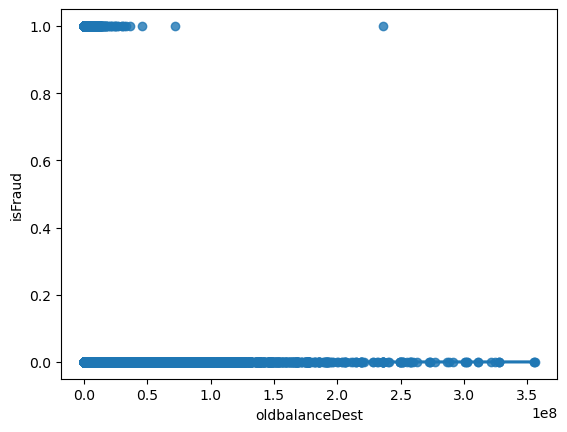

In [40]:
x_list = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
sns.regplot(x='oldbalanceDest', y="isFraud", data=df1_fraud, logistic=True, ci=None)

<Axes: xlabel='newbalanceDest', ylabel='isFraud'>

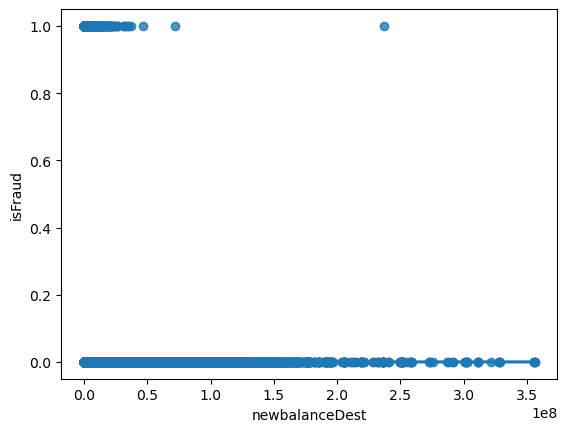

In [41]:
x_list = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
sns.regplot(x='newbalanceDest', y="isFraud", data=df1_fraud, logistic=True, ci=None)

# Using XGBoost, Boosting technique to train fraud prediction model. 

- Since logistic model is not good enough, then here we apply Stacking Model technique to predict fraud, it is always better than applying just one model.

Question: Why not using Random Forest instead?
Answer: Running Random Forest on 30% of training data causes my CPU memory buffered. I might choose to lower down the sample but it would be less reliable.Random Forest tend to use larger memories because of its nature of storing all of the decision trees while running, while XGBoost will forgo overly large tree, which is good for memory use.

In best case, we can use Random Forest because it requires less tuning while providing decent metric scores. However, if you are willing to invest to tune XGBoost Model, it works well too.

In [5]:
is_fraud = df['isFraud'].value_counts()

# GridSearch method for hyperparameter tuning

In [9]:
#define XGBoost model
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

#Set of hyperparameters
cv_params = {'max_depth': [4, 6],
              'min_child_weight': [3, 5],
               'learning_rate': [0.1, 0.2, 0.3],
              'n_estimators': [5,10,15],
             'subsample': [0.7],
              'colsample_bytree': [0.7]
            }
#ML important metric/scoring
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

#Calling GridSearch to determine the best parameter from the hyperparameter provided from cv_params variable
xgb_cv = GridSearchCV(xgb,
                      cv_params,
                      scoring = scoring,
                      cv = 5, #5 Fold Cross Validation
                      refit = 'f1' #Means we aim to find the best model to suit for optimal f1 score from the hyperparameter given
                     )


- %%time will tell you how much time does the model use to train the model by using one after one combination of parameter to train the model.
- Eventually, xgb_cv will only keep the best parameter model after running the GridSearchCV

In [ ]:
%%time
xgb_cv = xgb_cv.fit(x_train, y_train)
xgb_cv

- Training a model can really take a long time, here costs me for 22 minutes - half an hour.
- You might find your model takes more than half an hour to train, it's okay
- If it's more than 1 hour, please stop the running, because you might need to wait forever, then it is not feasible to run the model anymore.
- Unless you are sure your PC RAM is high enough, 32GB is considered a good one, but here I only have 8GB :(

In [ ]:
xgb_cv.best_params_

In [ ]:
#y_pred = (y_probs > 0.3).astype(int)
y_pred = xgb_cv.predict(x_test)

In [ ]:
# 1. Print your accuracy score.
ac_score = metrics.accuracy_score(y_test, y_pred)
print('accuracy score:', ac_score)

# 2. Print your precision score.
pc_score = metrics.precision_score(y_test, y_pred)
print('precision score:', pc_score)

# 3. Print your recall score.
rc_score = metrics.recall_score(y_test, y_pred)
print('recall score:', rc_score)

# 4. Print your f1 score.
f1_score = metrics.f1_score(y_test, y_pred)
print('f1 score:', f1_score)

- Display Confusion Matrix to see how many data point lie onto:
  1) True Positive: Model predict the transaction is fraud, and in real life(comparing the outcome from y-test) it's a fraud too.
  2) False Positive: Model predict the transaction is fraud, and in real life(comparing the outcome from y-test) it's not a fraud.
  3) True Negative: Model predict the transaction is not a fraud, and in real life(comparing the outcome from y-test) it's not a fraud too.
  4) False Negative: Model predict the transaction is not a fraud, and in real life(comparing the outcome from y-test) it's in fact a fraud.

In [ ]:
# Construct and display your confusion matrix.
# Construct the confusion matrix for your predicted and test values.
cm = metrics.confusion_matrix(y_test, y_pred)

# Create the display for your confusion matrix.
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_cv.classes_)

# Plot the visual in-line.
disp.plot()

# Using Best Parameter for XGBoost model

In [ ]:
%%time
xgb = XGBClassifier(objective='binary:logistic', random_state=0)
best_params = {'colsample_bytree': [0.7],
         'learning_rate': [0.2],
         'max_depth':[6],
         'min_child_weight': [5],
         'n_estimators': [15],
         'subsample': [0.7]}
xgb_model = GridSearchCV(xgb,
                      best_params,
                      scoring = scoring,
                      cv = 5,
                      refit = 'f1'
                     )
xgb_model = xgb_model.fit(x_train, y_train)
xgb_model

In [ ]:
pickle.dump(xgb_model, open('xgb_model.sav', 'wb'))

In [ ]:
best_y_pred = xgb_model.predict(x_test)

In [ ]:
# 1. Print your accuracy score.
ac_score = metrics.accuracy_score(y_test, best_y_pred)
print('accuracy score:', ac_score)

# 2. Print your precision score.
pc_score = metrics.precision_score(y_test, best_y_pred)
print('precision score:', pc_score)

# 3. Print your recall score.
rc_score = metrics.recall_score(y_test, best_y_pred)
print('recall score:', rc_score)

# 4. Print your f1 score.
f1_score = metrics.f1_score(y_test, best_y_pred)
print('f1 score:', f1_score)

In [ ]:
best_cm = metrics.confusion_matrix(y_test, best_y_pred)
best_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=best_cm, display_labels=xgb_model.classes_)
best_disp.plot()

In [ ]:
plot_importance(xgb_cv.best_estimator_)

In [ ]:
from sklearn.metrics import precision_recall_curve

y_probs = xgb_model.predict_proba(x_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
print(precision.mean())
print(recall.mean())
# Plot to visualize tradeoff
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.grid()
plt.show()

# RandomizedSearch CV for hyperparameter tuning

- The reason why I used RandomizedSearch CV because:
- It runs much faster than GridserchCV
- It can produce the near-optimal parameter that still good in real life

In [ ]:
#1st model trial
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [188]:
%%time
#2nd model trial
# Count ratio of classes (for scale_pos_weight)
ratio = df['isFraud'].value_counts()[0] / df['isFraud'].value_counts()[1]

xgb = XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',        # 'gpu_hist' if using GPU
    eval_metric='logloss',
    n_jobs=-1,
    scale_pos_weight=ratio  # handle class imbalance
)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_lambda': [0.1, 1, 10],
    'reg_alpha': [0, 0.1, 0.5, 1]
}

xgb_RS_model = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,  # number of combinations to try
    scoring=scoring,  
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,  # Use all CPUs
    random_state=42,
    refit='f1'
)

xgb_RS_model.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: total: 3min 7s
Wall time: 25min 28s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [0.1, 1, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, refit='f1',
                   scoring={'accuracy': 'accuracy', 'f1': 'f1',
                            'precision': 'precision', 'recall': 'recall'},
                   verbose=1)

In [189]:
xgb_RS_model.best_params_

{'subsample': 1.0,
 'reg_lambda': 0.1,
 'reg_alpha': 1,
 'n_estimators': 200,
 'max_depth': 10,
 'learning_rate': 0.2,
 'gamma': 0,
 'colsample_bytree': 0.6}

# Using best parameter from RandomizedSearchCV

In [239]:
ratio = df['isFraud'].value_counts()[0] / df['isFraud'].value_counts()[1]
best_xgb = XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    eval_metric='logloss',
    n_jobs=-1,
    scale_pos_weight=ratio,  # still use the same ratio from earlier
    subsample=1.0,
    reg_lambda=0.1,
    reg_alpha=1,
    n_estimators=200,
    max_depth=10,
    learning_rate=0.2,
    gamma=0,
    colsample_bytree=0.6,
    random_state=42
)

best_xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

In [225]:
model = best_xgb.fit(x_train, y_train)
y_preds = model.predict(x_test)

In [226]:
# 1. Print your accuracy score.
ac_score = metrics.accuracy_score(y_test, y_preds)
print('accuracy score:', ac_score)

# 2. Print your precision score.
pc_score = metrics.precision_score(y_test, y_preds)
print('precision score:', pc_score)

# 3. Print your recall score.
rc_score = metrics.recall_score(y_test, y_preds)
print('recall score:', rc_score)

# 4. Print your f1 score.
f1_score = metrics.f1_score(y_test, y_preds)
print('f1 score:', f1_score)

accuracy score: 0.9981518980945059
precision score: 0.6312910284463895
recall score: 0.9246794871794872
f1 score: 0.7503250975292588


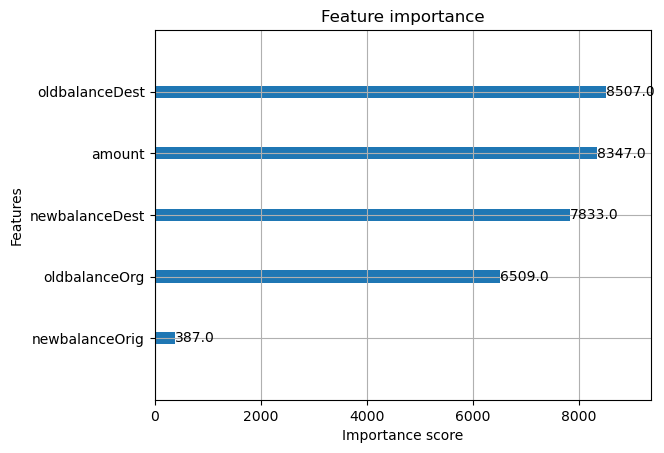

In [245]:
best_model = xgb_RS_model.best_estimator_

# Plot importance
plot_importance(best_model)
plt.show()

- Feature importance helps us to determine which feature(column) contribute to the model the most

Precision: 0.6636, Recall: 0.9127, F1: 0.7684


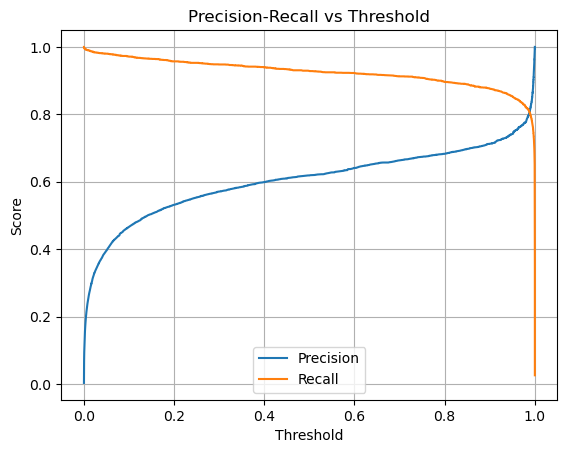

In [249]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
# Get predicted probabilities
y_probs = best_model.predict_proba(x_test)[:, 1]

# Try increasing threshold from 0.5 to 0.6 or 0.7
threshold = 0.7
y_pred_thresh = (y_probs > threshold).astype(int)

# Recalculate metrics
precision = precision_score(y_test, y_pred_thresh)
recall = recall_score(y_test, y_pred_thresh)
f1 = f1_score(y_test, y_pred_thresh)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

- Here I used matplotlib to sketch Precision-Recall Curve to understand the optimal threshold to reach the optimal outcome and metrics scores

In [177]:
# Get model probabilities for positive class
#y_probs = xgb_RS_model.best_estimator_.predict_proba(x_test)[:, 1]

# Get precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find where precision and recall are closest
diff = np.abs(precision - recall)
optimal_idx = np.argmin(diff)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold (precision ≈ recall): {optimal_threshold:.10f}")
print(f"Precision at threshold: {precision[optimal_idx]:.10f}")
print(f"Recall at threshold: {recall[optimal_idx]:.10f}")


Optimal threshold (precision ≈ recall): 0.9882109165
Precision at threshold: 0.8036858974
Recall at threshold: 0.8036858974


- Now we know the optimal threshold is 0.9882109165, where the both precision and recall curve intersect at

In [183]:
y_probs = best_xgb.predict_proba(x_test)[:, 1]  # Get probability for class 1
threshold = 0.9882
best_y_pred = (y_probs >= threshold).astype(int)  # Adjust prediction based on threshold

- Here I used .predict_proba() to adjust the threshold to reach the optimal metric score, instead of .predict() that set my threshold score at 0.5
- by default and cannot adjust.

In [185]:
# 1. Print your accuracy score.
ac_score = metrics.accuracy_score(y_test, best_y_pred)
print('accuracy score:', ac_score)

# 2. Print your precision score.
pc_score = metrics.precision_score(y_test, best_y_pred)
print('precision score:', pc_score)

# 3. Print your recall score.
rc_score = metrics.recall_score(y_test, best_y_pred)
print('recall score:', rc_score)

# 4. Print your f1 score.
f1_score = metrics.f1_score(y_test, best_y_pred)
print('f1 score:', f1_score)

accuracy score: 0.9988208724821717
precision score: 0.8036858974358975
recall score: 0.8036858974358975
f1 score: 0.8036858974358975


- Now the metric scores are good enough.

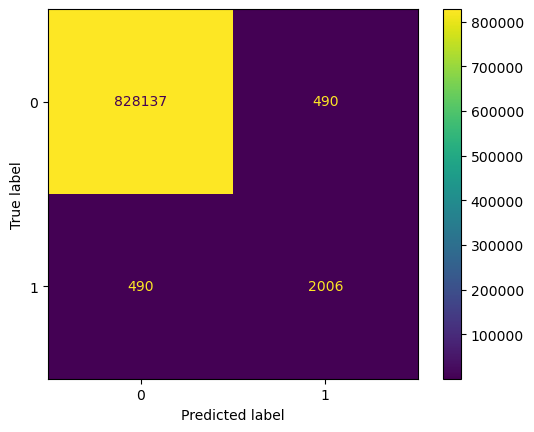

In [251]:
best_cm = metrics.confusion_matrix(y_test, best_y_pred)
best_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=best_cm, display_labels=best_xgb.classes_)
best_disp.plot()

# Benford's Law apply

- Using Benford's Law to detect anomaly, and pattern of transactions, preferably, distinguish the fraud and non-fraud transaction pattern.
- Documentation Link: https://pypi.org/project/benfordslaw/

- First graph never seperate both non-fraud and fraud transactions.

[benfordslaw] >Analyzing digit position: [1]
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=127463
P-Value: 0.0
Statistical Deviation: Significant
Digit Distribution (%): [[ 1.         33.59563114]
 [ 2.         20.4658775 ]
 [ 3.         12.54864449]
 [ 4.          8.27798811]
 [ 5.          6.22001959]
 [ 6.          5.25396669]
 [ 7.          4.8080405 ]
 [ 8.          4.51945843]
 [ 9.          4.31037355]]


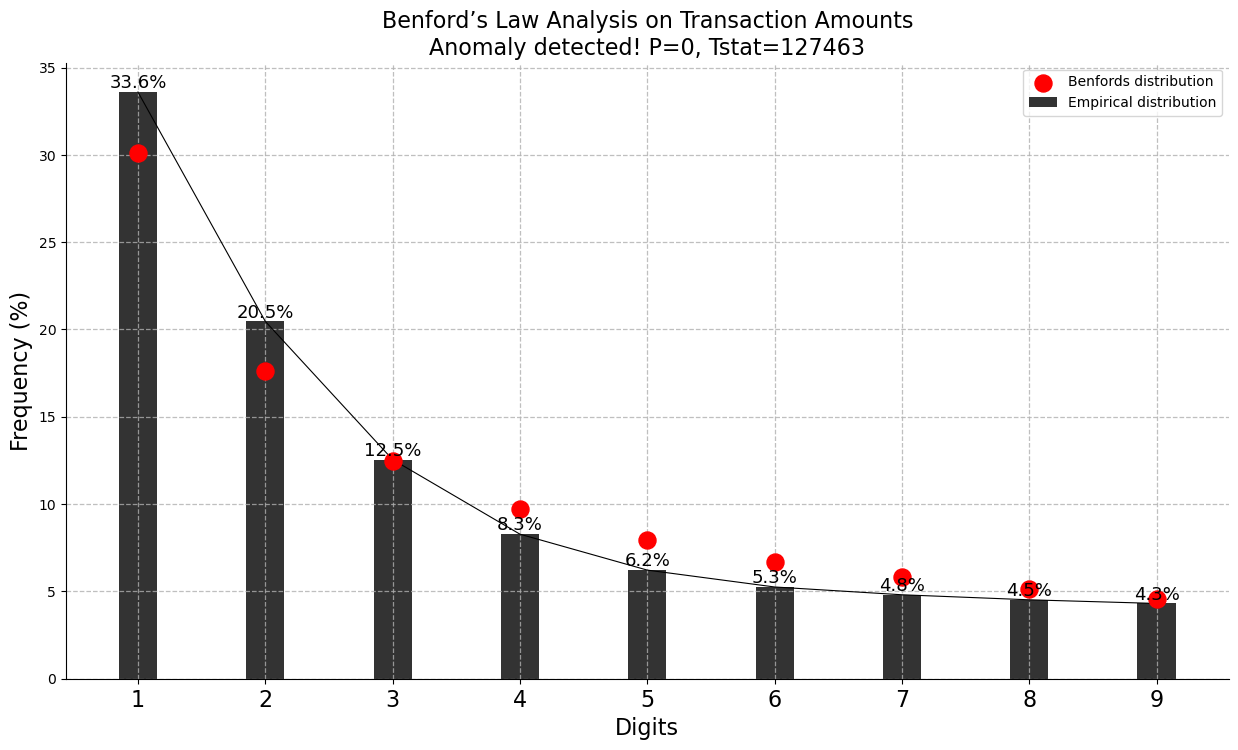

(<Figure size 1500x800 with 1 Axes>,
 <Axes: title={'center': 'Benford’s Law Analysis on Transaction Amounts\nAnomaly detected! P=0, Tstat=127463'}, xlabel='Digits', ylabel='Frequency (%)'>)

In [19]:
amounts = df['amount']  # replace with your column

# Apply Benford’s Law
bl = benfordslaw(alpha=0.05)
result = bl.fit(amounts)

# Output
print("P-Value:", result['P'])
print("Statistical Deviation:", "Significant" if result['P_significant'] else "Not Significant")
print("Digit Distribution (%):", result['percentage_emp'])

# Optional visualization
bl.plot(title='Benford’s Law Analysis on Transaction Amounts')

- Now I seperate out both fraud and non-fraud transactions, and sketch Benford's Law graph.
- Non-fraud graph will display first, then followed by fraud graph

[benfordslaw] >Analyzing digit position: [1]
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=127571
[benfordslaw] >Analyzing digit position: [1]
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=127571
Non-fraud Benford Test:


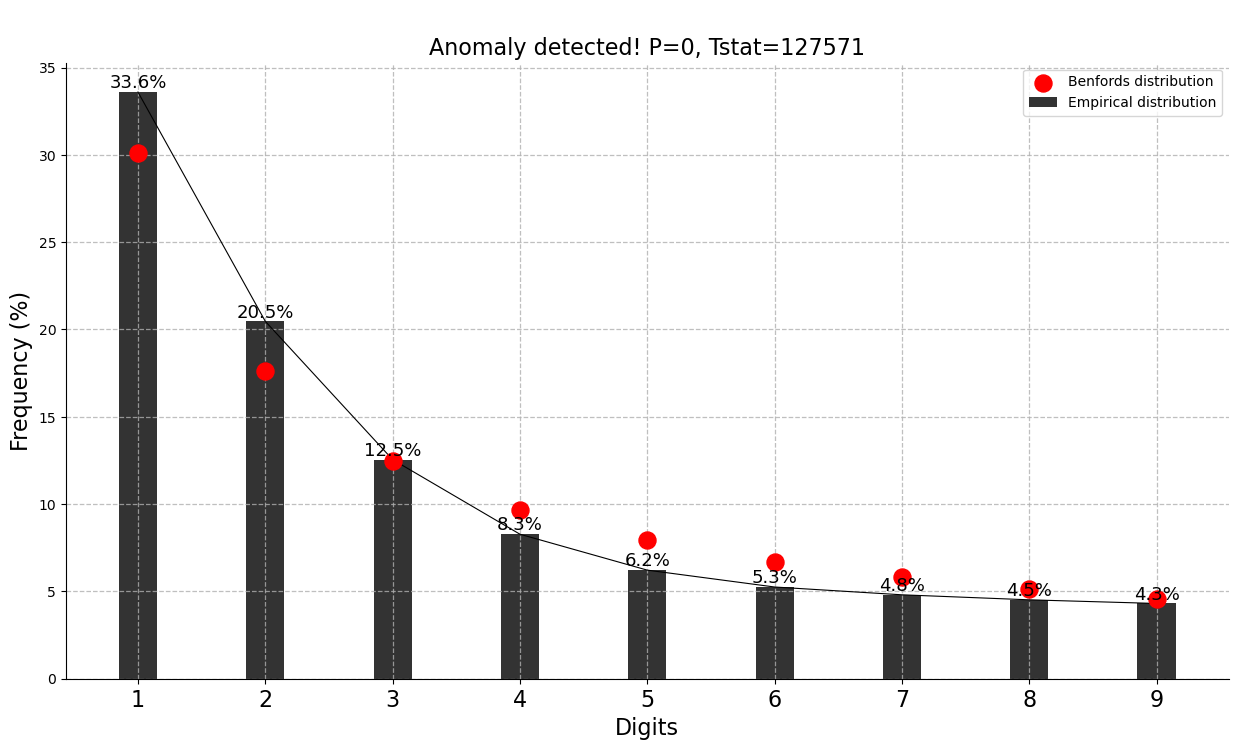

[benfordslaw] >Analyzing digit position: [1]
[benfordslaw] >[chi2] Anomaly detected! P=0.0300084, Tstat=17.0097
[benfordslaw] >Analyzing digit position: [1]
[benfordslaw] >[chi2] Anomaly detected! P=0.0300084, Tstat=17.0097
Fraud Benford Test:


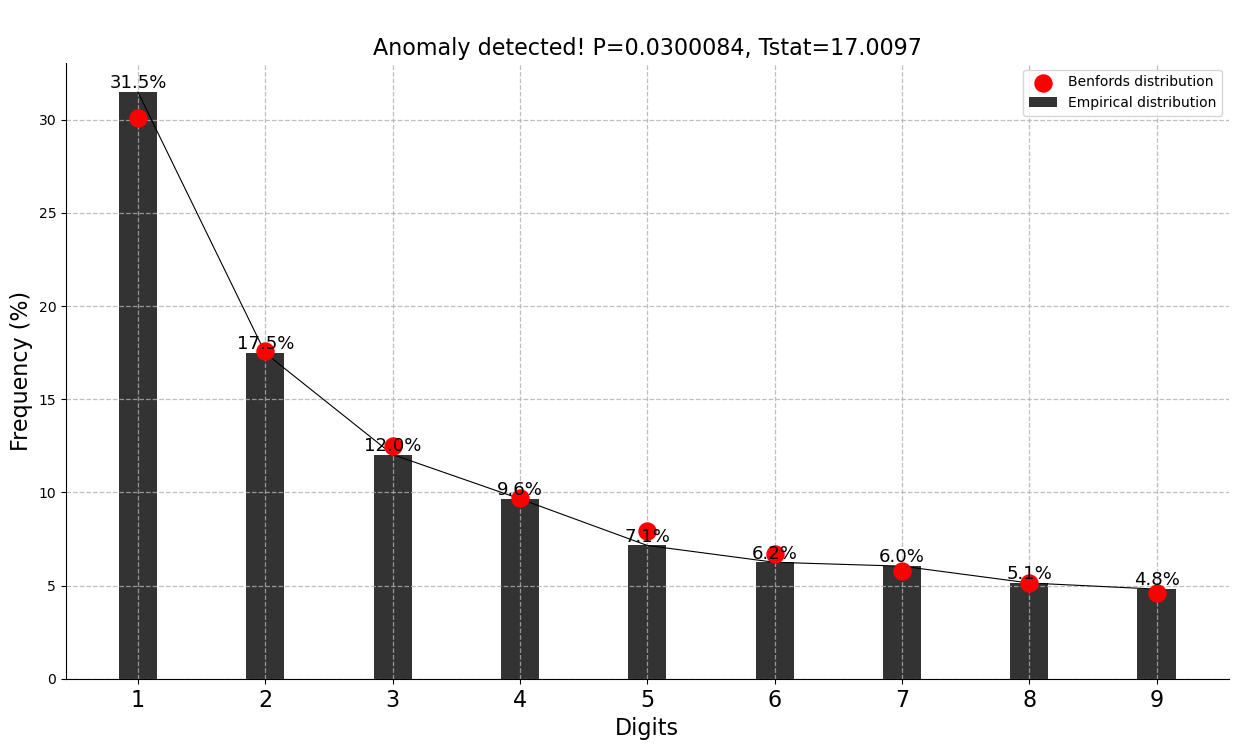

(<Figure size 1500x800 with 1 Axes>,
 <Axes: title={'center': '\nAnomaly detected! P=0.0300084, Tstat=17.0097'}, xlabel='Digits', ylabel='Frequency (%)'>)

In [14]:
# Split data
non_fraud = df[df['isFraud'] == 0]['amount']
fraud = df[df['isFraud'] == 1]['amount']

# Benford test on non-fraud
no_fraud_bl = bl.fit(non_fraud)
bl.fit(non_fraud)
print("Non-fraud Benford Test:")
bl.plot()

# Benford test on fraud
fraud_bl = bl.fit(fraud)
bl.fit(fraud)
print("Fraud Benford Test:")
bl.plot()


## Output
- P : P-value

- t : t-statistic

- P_significant : Boolean value that is set by alpha

- percentage_emp : Percentage distribution digits.

In [21]:
print("No fraud happens")
print(f"P-value: {no_fraud_bl['P']}")
print(f"t-statistic: {no_fraud_bl['t']}")
print(f"P_significant - Boolean value that is set by alpha: {no_fraud_bl['P_significant']}")
print(f"Percentage distribution digits: {no_fraud_bl['percentage_emp']}")
print()
print("Fraud happens")
print(f"P-value: {fraud_bl['P']}")
print(f"t-statistic: {fraud_bl['t']}")
print(f"P_significant - Boolean value that is set by alpha: {fraud_bl['P_significant']}")
print(f"Percentage distribution digits: {fraud_bl['percentage_emp']}")

No fraud happens
P-value: 0.0
t-statistic: 127570.61690792418
P_significant - Boolean value that is set by alpha: True
Percentage distribution digits: [[ 1.         33.59836684]
 [ 2.         20.46974242]
 [ 3.         12.5493151 ]
 [ 4.          8.27621839]
 [ 5.          6.21882127]
 [ 6.          5.25268673]
 [ 7.          4.80645284]
 [ 8.          4.51866306]
 [ 9.          4.30973338]]

Fraud happens
P-value: 0.03000842484189653
t-statistic: 17.009681492452938
P_significant - Boolean value that is set by alpha: True
Percentage distribution digits: [[ 1.         31.47492985]
 [ 2.         17.46980603]
 [ 3.         12.02879102]
 [ 4.          9.6498719 ]
 [ 5.          7.14895694]
 [ 6.          6.24618763]
 [ 7.          6.03879468]
 [ 8.          5.13602538]
 [ 9.          4.80663657]]


In [27]:
print(f"Standard Deviation: {non_fraud.std()}")
print(f"Mean: {non_fraud.mean()}")

Standard Deviation: 596236.9813471739
Mean: 178197.04172740763


In [29]:
print(f"Standard Deviation: {fraud.std()}")
print(f"Mean: {fraud.mean()}")

Standard Deviation: 2404252.9472401612
Mean: 1467967.299140387


- Now we noticed fraud transactions has narrower distribution spread.
- Means the fraud transaction try to be normal transaction.

# Test KMean model. 'amount' column

In [253]:
X = df[['amount']]  # Use double brackets to keep it 2D
x_scaled = StandardScaler().fit_transform(X)

- StandardScalar() convert the datapoint or row values specified into z-score, unlike the monetary value from 'amount' column.
- This helps KMean model to better identify the datapoint and categorize them.

# Optimal K value for KMean model

- We have 2 methods to determine optimal k value
- 1) KMean inertia: The catagorized data point center, called centroid. Inertia measures how tightly the data points in a cluster are grouped.
- Lower inertia means tighter, more compact clusters.
- Used in: The “elbow method” to find an optimal k by looking for a bend or “elbow” in the inertia plot.

- 2) Silhouette Score: Measures how similar a data point is to its own cluster vs other clusters.
- Range: Between –1 and 1
- Close to +1: well-matched to its own cluster and poorly matched to neighboring clusters
- Around 0: borderline or overlapping
- Negative: wrongly clustered

# Elbow's method

In [255]:
num_clusters = [i for i in range(2, 11)]

def kmeans_inertia(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints. 
    Returns each k-value's inertia appended to a list.
    """
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)

    return inertia

In [257]:
inertia = kmeans_inertia(num_clusters, x_scaled)
inertia

[2982719.3735115775,
 1986519.6442826926,
 1105893.9812985228,
 807915.0343112302,
 607842.6977697453,
 428516.113264238,
 345690.03642299067,
 290202.8103416532,
 217556.4894540456]

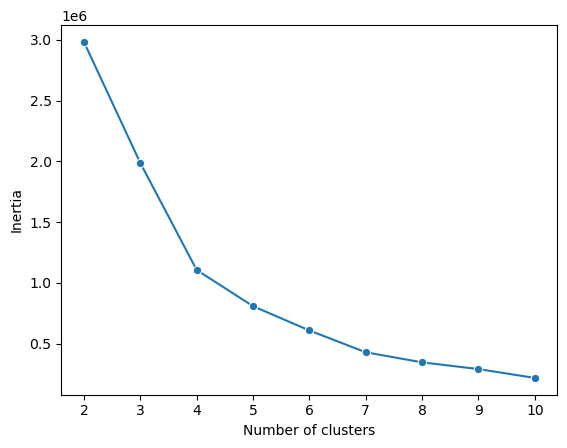

In [258]:
plot = sns.lineplot(x=num_clusters, y=inertia, marker = 'o')
plot.set_xlabel("Number of clusters");
plot.set_ylabel("Inertia");

- So now we find the ‘Elbow’
- Look for the point where the rate of decrease sharply slows down.
- Here we can see the graph goes down drastically to 4, then become less steeper start from 5, hence, best k value is 4

# Silhouette Score

In [40]:
%%time
# Scale the amount column
x_scaled = StandardScaler().fit_transform(df[['amount']])
# Sample 100,000 for speed
X_sample = resample(x_scaled, n_samples=100000, random_state=42)
# Store scores
sil_scores = []

for num in range(2, 11):
    start = time.time()
    kmeans = MiniBatchKMeans(n_clusters=num, random_state=42)
    labels = kmeans.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    end = time.time()
    print(f"Silhouette score for k={num}: {score:.4f} (Time taken: {end - start:.2f} sec)")
    sil_scores.append(score)



Silhouette score for k=2: 0.6387 (Time taken: 162.09 sec)
Silhouette score for k=3: 0.6084 (Time taken: 153.85 sec)
Silhouette score for k=4: 0.6534 (Time taken: 153.75 sec)
Silhouette score for k=5: 0.3870 (Time taken: 144.66 sec)
Silhouette score for k=6: 0.5327 (Time taken: 148.69 sec)
Silhouette score for k=7: 0.3699 (Time taken: 141.85 sec)
Silhouette score for k=8: 0.6240 (Time taken: 147.53 sec)
Silhouette score for k=9: 0.5625 (Time taken: 148.13 sec)
Silhouette score for k=10: 0.5367 (Time taken: 144.15 sec)
CPU times: total: 22min 10s
Wall time: 22min 24s


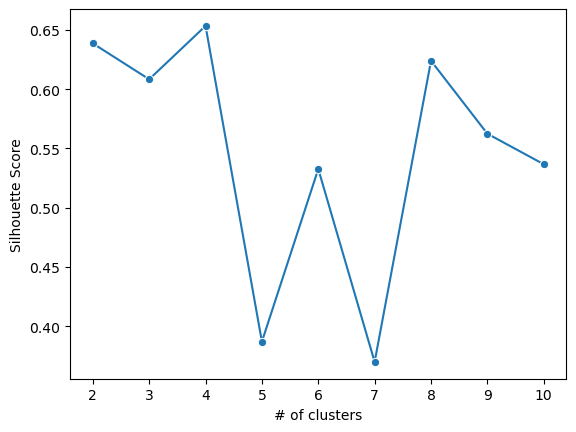

In [45]:
plot = sns.lineplot(x=num_clusters, y=sil_scores, marker = 'o')
plot.set_xlabel("# of clusters");
plot.set_ylabel("Silhouette Score");

- Here we pick the highest silhouette score, which is k value = 4, same as elbow's method.
- However, using silhoutte score is time-consuming for more data points, hence afterwards, I only adopted Elbow's method.

In [23]:
#Fit k value = 4;
kmeans4 = KMeans(n_clusters=4, random_state=42)
kmeans4.fit(x_scaled)
print('Unique labels:', np.unique(kmeans4.labels_))

Unique labels: [0 1 2 3]


In [24]:
df['amount_cluster'] = kmeans4.labels_
df.head(20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_cluster
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0,0


In [27]:
df['amount_cluster'].value_counts()

amount_cluster
0    6221456
2     130967
1       9390
3        807
Name: count, dtype: int64

In [29]:
# Verify if any `cluster` can be differentiated by `isFraud`.
df.groupby(by=['amount_cluster', 'isFraud']).size()

amount_cluster  isFraud
0               0          6216068
                1             5388
1               0             8726
                1              664
2               0           128806
                1             2161
3               0              807
dtype: int64

In [141]:
df.groupby(by=['amount_cluster', 'isFlaggedFraud']).size()

amount_cluster  isFlaggedFraud
0               0                 6221453
                1                       3
1               0                    9384
                1                       6
2               0                  130960
                1                       7
3               0                     807
dtype: int64

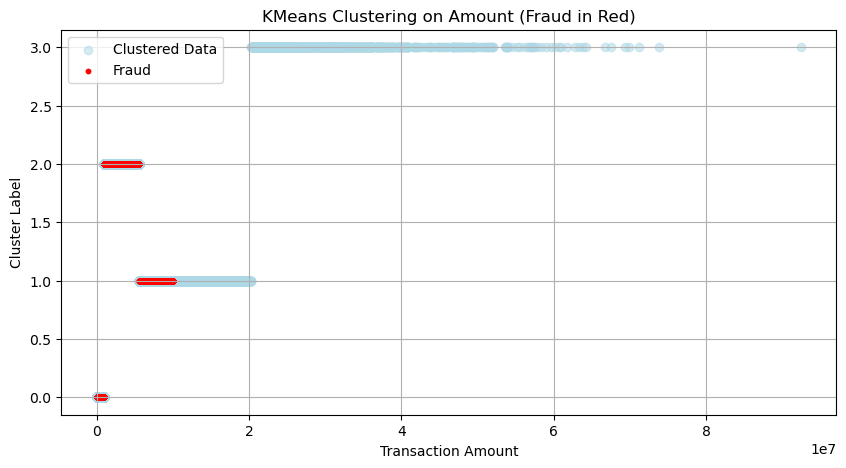

In [31]:
# Plot clusters along the 'amount' axis
plt.figure(figsize=(10, 5))
plt.scatter(df['amount'], df['amount_cluster'], c='lightblue', alpha=0.5, label='Clustered Data')

# Overlay fraud in red
fraud = df['isFraud'] == 1
plt.scatter(df[fraud]['amount'], df[fraud]['amount_cluster'], color='red', s=10, label='Fraud')

plt.xlabel("Transaction Amount")
plt.ylabel("Cluster Label")
plt.title("KMeans Clustering on Amount (Fraud in Red)")
plt.legend()
plt.grid(True)
plt.show()

- Now we can identify, and categorize there is 3 fraud transaction pattern based on the 'amount'.
- Cluster 0 is the lowest 'amount' yet most frequent fraud occurs.
- Cluster 2 is the medium 'amount' with second highest occurence of fraud.
- Cluster 1 is the highest 'amount' with least occurence of fraud.
- Cluster 3 has no fraud, and contains widespread 'amount' of transaction here, can be extremely high and low.

In [51]:
print(f"Cluster 0 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['amount_cluster'] == 0)]['amount'].min()} & Max = {df[(df['isFraud'] == 1) & (df['amount_cluster'] == 0)]['amount'].max()}")
print(f"Cluster 1 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['amount_cluster'] == 1)]['amount'].min()} & Max = {df[(df['isFraud'] == 1) & (df['amount_cluster'] == 1)]['amount'].max()}")
print(f"Cluster 2 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['amount_cluster'] == 2)]['amount'].min()} & Max = {df[(df['isFraud'] == 1) & (df['amount_cluster'] == 2)]['amount'].max()}")


Cluster 0 with isFraud = 1; Min = 0.0 & Max = 940957.88
Cluster 1 with isFraud = 1; Min = 5614246.07 & Max = 10000000.0
Cluster 2 with isFraud = 1; Min = 945131.71 & Max = 5591647.96


In [139]:
print(f"Cluster 0 with isFlaggedFraud = 1; Min = {df[(df['isFlaggedFraud'] == 1) & (df['amount_cluster'] == 0)]['amount'].min()} & Max = {df[(df['isFlaggedFraud'] == 1) & (df['amount_cluster'] == 0)]['amount'].max()}")
print(f"Cluster 1 with isFlaggedFraud = 1; Min = {df[(df['isFlaggedFraud'] == 1) & (df['amount_cluster'] == 1)]['amount'].min()} & Max = {df[(df['isFlaggedFraud'] == 1) & (df['amount_cluster'] == 1)]['amount'].max()}")
print(f"Cluster 2 with isFlaggedFraud = 1; Min = {df[(df['isFlaggedFraud'] == 1) & (df['amount_cluster'] == 2)]['amount'].min()} & Max = {df[(df['isFlaggedFraud'] == 1) & (df['amount_cluster'] == 2)]['amount'].max()}")


Cluster 0 with isFlaggedFraud = 1; Min = 353874.22 & Max = 536624.41
Cluster 1 with isFlaggedFraud = 1; Min = 5674547.89 & Max = 10000000.0
Cluster 2 with isFlaggedFraud = 1; Min = 1343002.08 & Max = 4953893.08


- Since Silhouette calculation is too slow, hence here we apply more relevant features, and use elbow method to get the best k value for each features

Inertia Graph for oldbalanceOrg
CPU times: total: 3min 49s
Wall time: 1min 34s


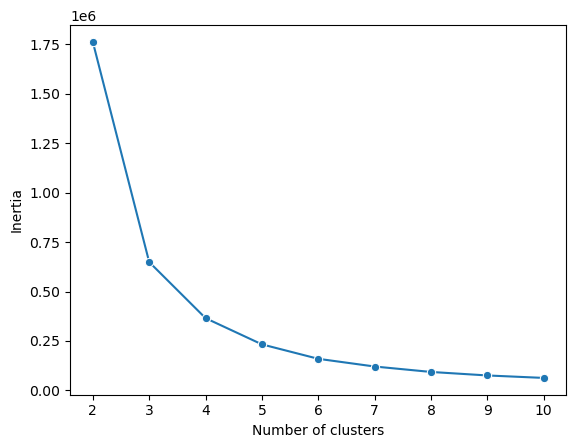

In [73]:
%%time
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'step']
X = df[['oldbalanceOrg']]  # Use double brackets to keep it 2D
x_scaled = StandardScaler().fit_transform(X)
inertia = kmeans_inertia(num_clusters, x_scaled)

print(f"Inertia Graph for oldbalanceOrg")
plot = sns.lineplot(x=num_clusters, y=inertia, marker = 'o')
plot.set_xlabel("Number of clusters");
plot.set_ylabel("Inertia");

- Best K Value is 3

In [74]:
X = df[['oldbalanceOrg']]  # Use double brackets to keep it 2D
x_scaled = StandardScaler().fit_transform(X)
oldbalanceOrg_kmeans3 = KMeans(n_clusters=3, random_state=42)
oldbalanceOrg_kmeans3.fit(x_scaled)
print('Unique labels:', np.unique(oldbalanceOrg_kmeans3.labels_))
df['oldbalanceOrg_cluster'] = oldbalanceOrg_kmeans3.labels_
df.groupby(by=['oldbalanceOrg_cluster', 'isFraud']).size()

Unique labels: [0 1 2]


oldbalanceOrg_cluster  isFraud
0                      0          5878935
                       1             7181
1                      0            89379
                       1              100
2                      0           386093
                       1              932
dtype: int64

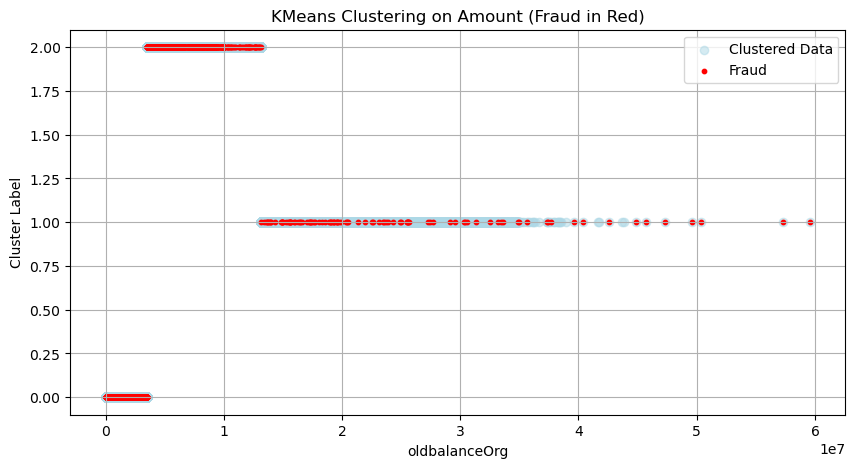

In [66]:
plt.figure(figsize=(10, 5))
plt.scatter(df['oldbalanceOrg'], df['oldbalanceOrg_cluster'], c='lightblue', alpha=0.5, label='Clustered Data')

# Overlay fraud in red
fraud = df['isFraud'] == 1
plt.scatter(df[fraud]['amount'], df[fraud]['oldbalanceOrg_cluster'], color='red', s=10, label='Fraud')

plt.xlabel("oldbalanceOrg")
plt.ylabel("Cluster Label")
plt.title("KMeans Clustering on Amount (Fraud in Red)")
plt.legend()
plt.grid(True)
plt.show()

- Now we can identify, and categorize there is 3 fraud transaction pattern based on the 'amount'.
- Cluster 0 is the lowest 'amount' yet most frequent fraud occurs.
- Cluster 2 is the medium 'amount' with second highest occurence of fraud.
- Cluster 1 is the highest 'amount' with least occurence of fraud.

In [61]:
print(f"Cluster 0 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['oldbalanceOrg_cluster'] == 0)]['oldbalanceOrg'].min()} & Max = {df[(df['isFraud'] == 1) & (df['oldbalanceOrg_cluster'] == 0)]['oldbalanceOrg'].max()}")
print(f"Cluster 1 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['oldbalanceOrg_cluster'] == 1)]['oldbalanceOrg'].min()} & Max = {df[(df['isFraud'] == 1) & (df['oldbalanceOrg_cluster'] == 1)]['oldbalanceOrg'].max()}")
print(f"Cluster 2 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['oldbalanceOrg_cluster'] == 2)]['oldbalanceOrg'].min()} & Max = {df[(df['isFraud'] == 1) & (df['oldbalanceOrg_cluster'] == 2)]['oldbalanceOrg'].max()}")

Cluster 0 with isFraud = 1; Min = 0.0 & Max = 10399045.08
Cluster 1 with isFraud = 1; Min = 7335355.57 & Max = 59585040.37
Cluster 2 with isFraud = 1; Min = 0.0 & Max = 7246962.16


Inertia Graph for oldbalanceOrg
CPU times: total: 4min 14s
Wall time: 1min 44s


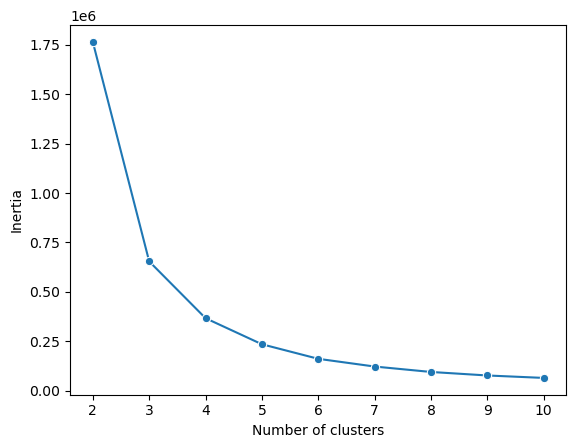

In [75]:
%%time
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'step']
X = df[['newbalanceOrig']]  # Use double brackets to keep it 2D
x_scaled = StandardScaler().fit_transform(X)
inertia = kmeans_inertia(num_clusters, x_scaled)

print(f"Inertia Graph for oldbalanceOrg")
plot = sns.lineplot(x=num_clusters, y=inertia, marker = 'o')
plot.set_xlabel("Number of clusters");
plot.set_ylabel("Inertia");

- Correct name: Inertia Graph for newbalanceOrig
- Best K Value is 3

In [76]:
X = df[['newbalanceOrig']]  # Use double brackets to keep it 2D
x_scaled = StandardScaler().fit_transform(X)
newbalanceOrig_kmeans3 = KMeans(n_clusters=3, random_state=42)
newbalanceOrig_kmeans3.fit(x_scaled)
print('Unique labels:', np.unique(newbalanceOrig_kmeans3.labels_))
df['newbalanceOrig_cluster'] = newbalanceOrig_kmeans3.labels_
df.groupby(by=['newbalanceOrig_cluster', 'isFraud']).size()

Unique labels: [0 1 2]


newbalanceOrig_cluster  isFraud
0                       0          5867812
                        1             8109
1                       0            90299
                        1               45
2                       0           396296
                        1               59
dtype: int64

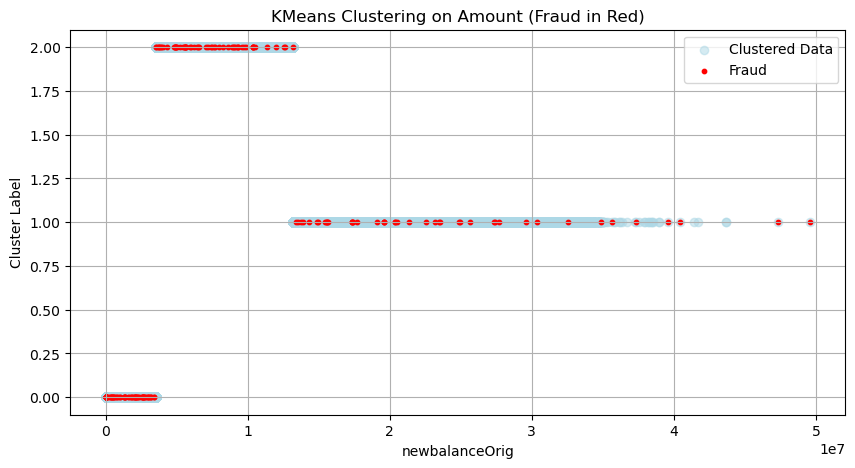

In [78]:
plt.figure(figsize=(10, 5))
plt.scatter(df['newbalanceOrig'], df['newbalanceOrig_cluster'], c='lightblue', alpha=0.5, label='Clustered Data')

# Overlay fraud in red
fraud = df['isFraud'] == 1
plt.scatter(df[fraud]['newbalanceOrig'], df[fraud]['newbalanceOrig_cluster'], color='red', s=10, label='Fraud')

plt.xlabel("newbalanceOrig")
plt.ylabel("Cluster Label")
plt.title("KMeans Clustering on Amount (Fraud in Red)")
plt.legend()
plt.grid(True)
plt.show()

- Same pattern as 'amount'.
- Cluster 0 has most fraud occurence, with 8109 cases, but with least 'amount' because in 'newbalanceOrig' the remaining monetary balance are depleted
- Cluster 2 has second highest fraud occurence, with medium amount.
- Cluster 1 has least fraud occurence, with highest 'newbalanceOrig' amount.

In [79]:
print(f"Cluster 0 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['newbalanceOrig_cluster'] == 0)]['newbalanceOrig'].min()} & Max = {df[(df['isFraud'] == 1) & (df['newbalanceOrig_cluster'] == 0)]['newbalanceOrig'].max()}")
print(f"Cluster 1 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['newbalanceOrig_cluster'] == 1)]['newbalanceOrig'].min()} & Max = {df[(df['isFraud'] == 1) & (df['newbalanceOrig_cluster'] == 1)]['newbalanceOrig'].max()}")
print(f"Cluster 2 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['newbalanceOrig_cluster'] == 2)]['newbalanceOrig'].min()} & Max = {df[(df['isFraud'] == 1) & (df['newbalanceOrig_cluster'] == 2)]['newbalanceOrig'].max()}")


Cluster 0 with isFraud = 1; Min = 0.0 & Max = 3441041.46
Cluster 1 with isFraud = 1; Min = 13441041.46 & Max = 49585040.37
Cluster 2 with isFraud = 1; Min = 3576297.1 & Max = 13171085.59


Inertia Graph for oldbalanceOrg
CPU times: total: 7min 9s
Wall time: 2min 26s


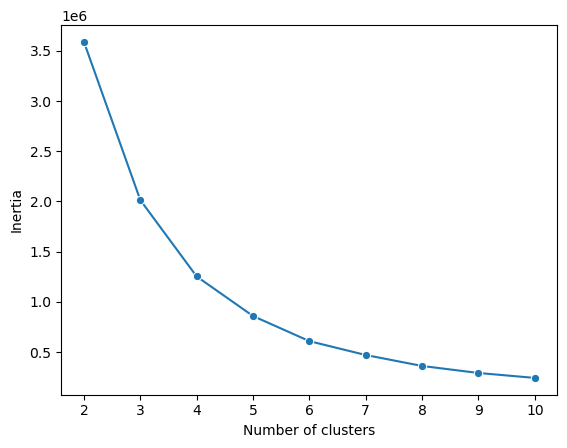

In [76]:
%%time
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'step']
X = df[['oldbalanceDest']]  # Use double brackets to keep it 2D
x_scaled = StandardScaler().fit_transform(X)
inertia = kmeans_inertia(num_clusters, x_scaled)

print(f"Inertia Graph for oldbalanceOrg")
plot = sns.lineplot(x=num_clusters, y=inertia, marker = 'o')
plot.set_xlabel("Number of clusters");
plot.set_ylabel("Inertia");

- Correct Graph: Inertia Graph for oldbalanceDest
- Best k value is 4

In [82]:
X = df[['oldbalanceDest']]  # Use double brackets to keep it 2D
x_scaled = StandardScaler().fit_transform(X)
oldbalanceDest_kmeans4 = KMeans(n_clusters=4, random_state=42)
oldbalanceDest_kmeans4.fit(x_scaled)
print('Unique labels:', np.unique(oldbalanceDest_kmeans4.labels_))
df['oldbalanceDest_cluster'] = oldbalanceDest_kmeans4.labels_
df.groupby(by=['oldbalanceDest_cluster', 'isFraud']).size()

Unique labels: [0 1 2 3]


oldbalanceDest_cluster  isFraud
0                       0           452209
                        1              259
1                       0            30456
                        1               20
2                       0          5870122
                        1             7932
3                       0             1620
                        1                2
dtype: int64

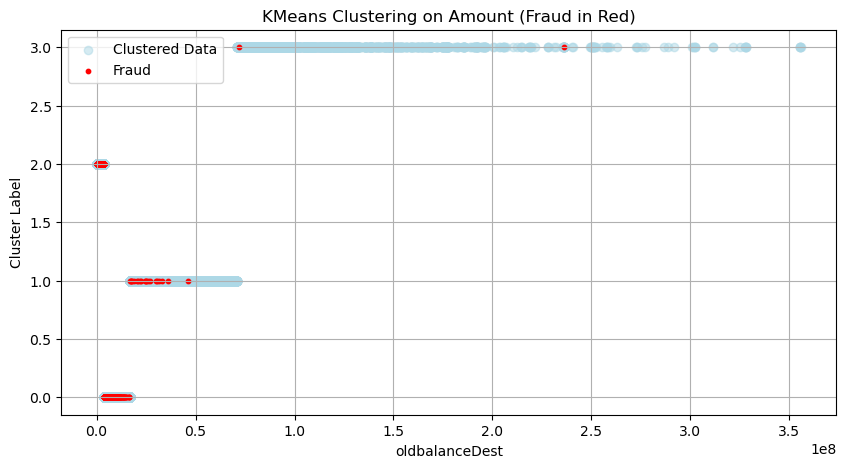

In [93]:
plt.figure(figsize=(10, 5))
plt.scatter(df['oldbalanceDest'], df['oldbalanceDest_cluster'], c='lightblue', alpha=0.5, label='Clustered Data')

# Overlay fraud in red
fraud = df['isFraud'] == 1
plt.scatter(df[fraud]['oldbalanceDest'], df[fraud]['oldbalanceDest_cluster'], color='red', s=10, label='Fraud')

plt.xlabel("oldbalanceDest")
plt.ylabel("Cluster Label")
plt.title("KMeans Clustering on Amount (Fraud in Red)")
plt.legend()
plt.grid(True)
plt.show()

In [98]:
print(f"Cluster 0 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['oldbalanceDest_cluster'] == 0)]['oldbalanceDest'].min()} & Max = {df[(df['isFraud'] == 1) & (df['oldbalanceDest_cluster'] == 0)]['oldbalanceDest'].max()}")
print(f"Cluster 1 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['oldbalanceDest_cluster'] == 1)]['oldbalanceDest'].min()} & Max = {df[(df['isFraud'] == 1) & (df['oldbalanceDest_cluster'] == 1)]['oldbalanceDest'].max()}")
print(f"Cluster 2 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['oldbalanceDest_cluster'] == 2)]['oldbalanceDest'].min()} & Max = {df[(df['isFraud'] == 1) & (df['oldbalanceDest_cluster'] == 2)]['oldbalanceDest'].max()}")
print(f"Cluster 3 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['oldbalanceDest_cluster'] == 3)]['oldbalanceDest'].min()} & Max = {df[(df['isFraud'] == 1) & (df['oldbalanceDest_cluster'] == 3)]['oldbalanceDest'].max()}")


Cluster 0 with isFraud = 1; Min = 3734511.97 & Max = 16606636.44
Cluster 1 with isFraud = 1; Min = 17051087.32 & Max = 46141756.44
Cluster 2 with isFraud = 1; Min = 0.0 & Max = 3709348.65
Cluster 3 with isFraud = 1; Min = 71836828.02 & Max = 236230516.82


Inertia Graph for oldbalanceOrg
CPU times: total: 5min 25s
Wall time: 2min 2s


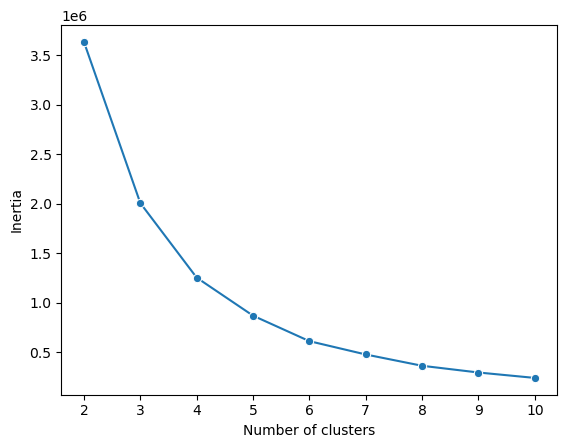

In [77]:
%%time
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'step']
X = df[['newbalanceDest']]  # Use double brackets to keep it 2D
x_scaled = StandardScaler().fit_transform(X)
inertia = kmeans_inertia(num_clusters, x_scaled)

print(f"Inertia Graph for oldbalanceOrg")
plot = sns.lineplot(x=num_clusters, y=inertia, marker = 'o')
plot.set_xlabel("Number of clusters");
plot.set_ylabel("Inertia");

- Correct Graph: Inertia Graph for newbalanceDest
- Best k value is 4

In [102]:
X = df[['newbalanceDest']]  # Use double brackets to keep it 2D
x_scaled = StandardScaler().fit_transform(X)
newbalanceDest_kmeans4 = KMeans(n_clusters=4, random_state=42)
newbalanceDest_kmeans4.fit(x_scaled)
print('Unique labels:', np.unique(newbalanceDest_kmeans4.labels_))
df['newbalanceDest_cluster'] = newbalanceDest_kmeans4.labels_
df.groupby(by=['newbalanceDest_cluster', 'isFraud']).size()

Unique labels: [0 1 2 3]


newbalanceDest_cluster  isFraud
0                       0          5858904
                        1             7403
1                       0            29617
                        1               24
2                       0           464114
                        1              785
3                       0             1772
                        1                1
dtype: int64

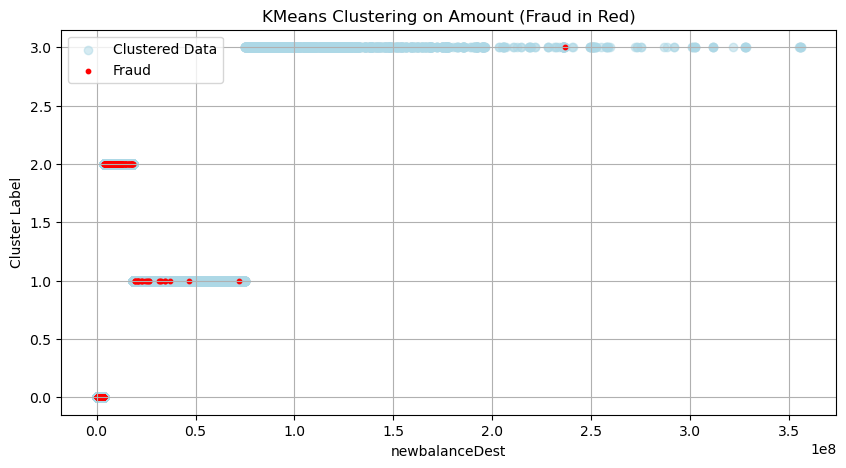

In [103]:
plt.figure(figsize=(10, 5))
plt.scatter(df['newbalanceDest'], df['newbalanceDest_cluster'], c='lightblue', alpha=0.5, label='Clustered Data')

# Overlay fraud in red
fraud = df['isFraud'] == 1
plt.scatter(df[fraud]['newbalanceDest'], df[fraud]['newbalanceDest_cluster'], color='red', s=10, label='Fraud')

plt.xlabel("newbalanceDest")
plt.ylabel("Cluster Label")
plt.title("KMeans Clustering on Amount (Fraud in Red)")
plt.legend()
plt.grid(True)
plt.show()

In [104]:
print(f"Cluster 0 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['newbalanceDest_cluster'] == 0)]['newbalanceDest'].min()} & Max = {df[(df['isFraud'] == 1) & (df['newbalanceDest_cluster'] == 0)]['newbalanceDest'].max()}")
print(f"Cluster 1 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['newbalanceDest_cluster'] == 1)]['newbalanceDest'].min()} & Max = {df[(df['isFraud'] == 1) & (df['newbalanceDest_cluster'] == 1)]['newbalanceDest'].max()}")
print(f"Cluster 2 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['newbalanceDest_cluster'] == 2)]['newbalanceDest'].min()} & Max = {df[(df['isFraud'] == 1) & (df['newbalanceDest_cluster'] == 2)]['newbalanceDest'].max()}")
print(f"Cluster 3 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['newbalanceDest_cluster'] == 3)]['newbalanceDest'].min()} & Max = {df[(df['isFraud'] == 1) & (df['newbalanceDest_cluster'] == 3)]['newbalanceDest'].max()}")


Cluster 0 with isFraud = 1; Min = 0.0 & Max = 3940408.54
Cluster 1 with isFraud = 1; Min = 19277671.71 & Max = 71970460.27
Cluster 2 with isFraud = 1; Min = 3950629.6 & Max = 18267760.5
Cluster 3 with isFraud = 1; Min = 236726494.66 & Max = 236726494.66


Inertia Graph for oldbalanceOrg
CPU times: total: 2min 13s
Wall time: 1min 9s


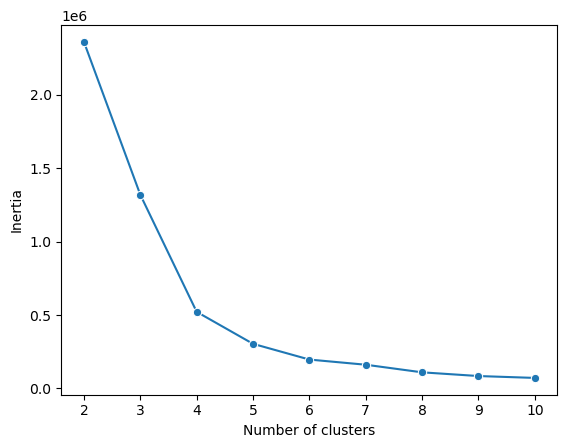

In [78]:
%%time
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'step']
X = df[['step']]  # Use double brackets to keep it 2D
x_scaled = StandardScaler().fit_transform(X)
inertia = kmeans_inertia(num_clusters, x_scaled)

print(f"Inertia Graph for oldbalanceOrg")
plot = sns.lineplot(x=num_clusters, y=inertia, marker = 'o')
plot.set_xlabel("Number of clusters");
plot.set_ylabel("Inertia");

- Correct Graph: Inertia Graph for step
- Best k value is 4

In [106]:
X = df[['step']]  # Use double brackets to keep it 2D
x_scaled = StandardScaler().fit_transform(X)
step_kmeans4 = KMeans(n_clusters=4, random_state=42)
step_kmeans4.fit(x_scaled)
print('Unique labels:', np.unique(step_kmeans4.labels_))
df['step_cluster'] = step_kmeans4.labels_
df.groupby(by=['step_cluster', 'isFraud']).size()

Unique labels: [0 1 2 3]


step_cluster  isFraud
0             0          2549628
              1             1705
1             0          2407191
              1             2168
2             0          1058326
              1             1312
3             0           339262
              1             3028
dtype: int64

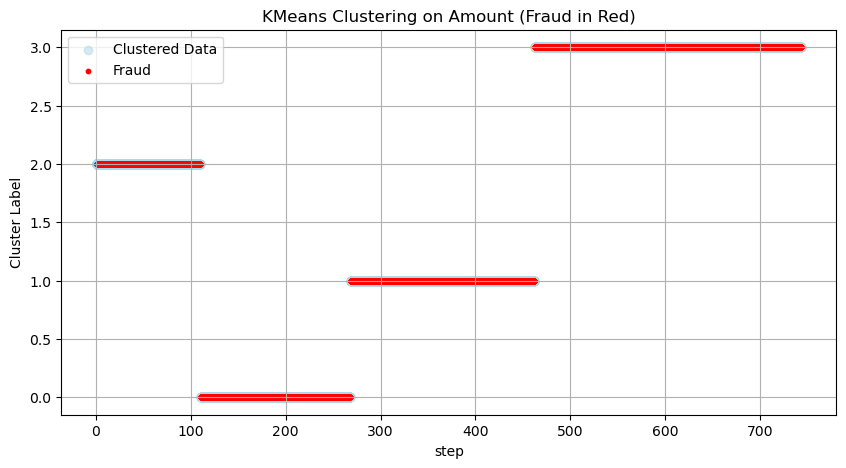

In [107]:
plt.figure(figsize=(10, 5))
plt.scatter(df['step'], df['step_cluster'], c='lightblue', alpha=0.5, label='Clustered Data')

# Overlay fraud in red
fraud = df['isFraud'] == 1
plt.scatter(df[fraud]['step'], df[fraud]['step_cluster'], color='red', s=10, label='Fraud')

plt.xlabel("step")
plt.ylabel("Cluster Label")
plt.title("KMeans Clustering on Amount (Fraud in Red)")
plt.legend()
plt.grid(True)
plt.show()

In [108]:
print(f"Cluster 0 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['step_cluster'] == 0)]['step'].min()} & Max = {df[(df['isFraud'] == 1) & (df['step_cluster'] == 0)]['step'].max()}")
print(f"Cluster 1 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['step_cluster'] == 1)]['step'].min()} & Max = {df[(df['isFraud'] == 1) & (df['step_cluster'] == 1)]['step'].max()}")
print(f"Cluster 2 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['step_cluster'] == 2)]['step'].min()} & Max = {df[(df['isFraud'] == 1) & (df['step_cluster'] == 2)]['step'].max()}")
print(f"Cluster 3 with isFraud = 1; Min = {df[(df['isFraud'] == 1) & (df['step_cluster'] == 3)]['step'].min()} & Max = {df[(df['isFraud'] == 1) & (df['step_cluster'] == 3)]['step'].max()}")


Cluster 0 with isFraud = 1; Min = 111 & Max = 268
Cluster 1 with isFraud = 1; Min = 269 & Max = 462
Cluster 2 with isFraud = 1; Min = 1 & Max = 110
Cluster 3 with isFraud = 1; Min = 463 & Max = 743


In [162]:
df[(df['type'] == 'CASH_OUT') & (df['isFraud'] == 1)].head(10)
df[(df['type'] == 'CASH_OUT') & (df['isFraud'] == 1)]['newbalanceOrig'].value_counts()

newbalanceOrig
0.00         4115
298767.61       1
Name: count, dtype: int64

In [174]:
df[(df['type'] == 'TRANSFER') & (df['isFraud'] == 1)].head(10)
num = df[(df['type'] == 'TRANSFER') & (df['isFraud'] == 1) & (df['newbalanceOrig'] == 0.00)]['newbalanceOrig'].value_counts().sum()
print(f"newbalanceOrig: {(num/4097) * 100}%")

newbalanceOrig: 96.11911154503295%


In [170]:
df[(df['type'] == 'TRANSFER') & (df['isFraud'] == 1)]['newbalanceOrig'].value_counts()

newbalanceOrig
0.00           3938
10399045.08       3
17316255.05       3
19585040.37       3
5674547.89        2
               ... 
2056779.24        1
653151.55         1
9299230.13        1
6580427.81        1
4339822.23        1
Name: count, Length: 144, dtype: int64

In [134]:
print(f"Flagged Fraud Min:{df[df['isFlaggedFraud'] == 1]['amount'].min()} & Max:{df[df['isFlaggedFraud'] == 1]['amount'].max()}")

Flagged Fraud Min:353874.22 & Max:10000000.0


In [144]:
df[df['isFraud'] == 1]['type'].value_counts()

type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64

# Conclusion

# i)Possible Causes of Financial Fraud of depleting the user bank account

# 1) Social Engineering
# 1)a) Phishing
- Fraudsters send fake messages or websites pretending to be:
- Bank personnel, Government body, customer service agent, and etc.
- Their messages often instil a sense of urgency or threat to panick the users to fasten the process of filling the credential or confidential informations, often accompany with a sense of formality rather than brute language to act as if an official personnel.
- It often occurs in the form of emails, SMS(smishing), calls(vishing), or fake login websites.
- Once the user filling the credentials, hence they used the credential to steal the access of the bank account, and deplete the saving.
- Some people might think they can discern the phishing email nowadays, however, in fact it still pose difficulty to identify the authenticity of the email. https://phishingquiz.withgoogle.com/. Here is the interesting website to test whether you can discern the phishing messages or not.

# 1)b) Deepfake Monetary Scam
- Fraudsters used deepfake, which they convert their face into somebody whom is well-known, professional and with high authority. Spreading wrong informations, therefore inducing the users to put their money in.

# 1)c) SIM - Swap
- Fraudsters obtain a sufficient amount of user personal information, thus request the SIM-Card vendor to 'swap' the SIM Card with the real owner. They used this credential to verify their identity of the victim bank account. For example, fraudster do not know the password, they used SMS to change and retrieve it instead.

# 2)Advanced Hacker Technique
- It rarely happen in real life. For example, keylogger that track the user keystroke to obtain their bank account and password. MITM attack that oversee user activity when accessing their bank account in public.

# ii)Why does bank account depletion fraud happen the most frequent among those who owns lower bank saving in their account?
- Because lower balance, lower suspiscion. Bank system rarely detect when a user depleting their bank transfer at lower amount, and deem it as normal transaction instead. Depleting larger saving account has higher risk of getting freezed of the user's bank account, and raise suspicion of fraudsters' activities.

# iii) Is there any improvement of this project?
- Yes.
- For example, we could trace originate user id and destination user id, we might be able to detect the suspects of conducting fraud.
- I should have used higher capacity of CPU to train the model, to ensure better model stacking and prediction accuracy.
- In this dataset, most of the transfer fraud's bank account are depleted, how about the non-depleted bank account yet facing the financial fraud?
- I should have import pickle to store the model I trained before. I do not need to rerun and wait to retrain the model over and over again once I reopen this file.
- The 0.9882 threshold looks unrealistic, despite it fits well for the model in this project.